# GLAMOS pre-processing:

### Imports:

In [1]:
import os
from os import listdir
from os.path import isfile, join
import warnings

# Import scripts:
from scripts.wgs84_ch1903 import *
from scripts.xgb_helpers import *
from scripts.glamos_preprocess import *
from scripts.stakes_processing import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Index files:
Index-stake mass balance data. 
- cumulative mb
- mb

### Transform MB .dat files to .csv:

In [2]:
# Get all files (only mass balance not cumulative):
glamosfiles_mb = []
for file in os.listdir(path_index_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_index_raw, file)):
        if file[-6:] == 'mb.dat':
            glamosfiles_mb.append(file)
print('Index stake raw files:\n', glamosfiles_mb[:5])

# Transform all files to csv
RUN = True
if RUN:
    emptyfolder(path_GLAMOS_csv)
    for file in glamosfiles_mb:
        fileName = file[:-4]
        processDatFile(fileName, path_index_raw, path_GLAMOS_csv)

# test:
fileName = 'aletsch_P11_mb.csv'
aletsch_csv = pd.read_csv(path_GLAMOS_csv + fileName, sep=',', header=0)
aletsch_csv.head(2)

Index stake raw files:
 ['limmern_P3_mb.dat', 'aletsch_P9_mb.dat', 'silvretta_BU_mb.dat', 'findelen_400_mb.dat', 'murtel_P3_mb.dat']


,# id,date0,date_fmeas,date_fmin,date_smeas,date_smax,date1,x,y,z,...,c_w_obs,a_w_obs,c_a_obs,a_a_obs,b_w_fix,b_a_fix,c_w_fix,a_w_fix,c_a_fix,a_a_fix
0,0,19201001,1001,810,430,528,19210930,644570,156375,3445.3,...,775,-16,1919,-614,759,1304,775,-16,1919,-614
1,0,19211001,1001,812,430,519,19220930,644570,156375,3445.0,...,2399,-33,3962,-369,2365,3592,2399,-33,3962,-369


### Measurement ids:
There are different ids depending on the method of analysis/evaluation:
- 0 : no measurements, only model results
- 1 : analysis of seasonal stake observations   (b_w & b_a)
- 2 : analysis of annual stake observations but not close to the end of the
         period   (b_w)
- 3 : analysis of annual stake observations   (b_a)

In [3]:
# check ID of glaciers:
ids_ = {}
for file in os.listdir(path_GLAMOS_csv):
    gl = file.split('_')[0]
    df = pd.read_csv(path_GLAMOS_csv + file, sep=',', header=0)
    if gl not in ids_.keys():
        ids_[gl] = df['# id'].unique()
    else:
        ids_[gl] = np.concatenate([df['# id'].unique(), ids_[gl]])
ids_

{'basodino': array([1, 2, 1, 1, 2]),
 'sanktanna': array([1]),
 'findelen': array([2, 3, 1, 1, 3, 2, 2, 3, 1, 1, 3, 2]),
 'adler': array([3, 1]),
 'tsanfleuron': array([1, 2, 0, 1, 3]),
 'gries': array([3, 1, 3, 1]),
 'rhone': array([1, 3, 1, 1]),
 'schwarzberg': array([1, 0, 2, 3]),
 'aletsch': array([1, 2, 0, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 3, 0, 1, 2]),
 'limmern': array([3, 0, 1, 3, 0, 1, 3, 0, 1]),
 'pizol': array([1, 2, 1]),
 'plainemorte': array([1]),
 'clariden': array([1, 0, 3, 0, 3, 1]),
 'allalin': array([1, 3, 2]),
 'silvretta': array([2, 0, 1, 3, 0, 2, 1, 3, 0, 3, 1]),
 'hohlaub': array([1, 0, 2, 3]),
 'pers': array([3, 0, 1, 3, 1]),
 'murtel': array([1, 1]),
 'corbassiere': array([3]),
 'plattalva': array([3, 0, 1, 3, 0, 1]),
 'gietro': array([3, 0, 1, 3, 0, 3, 0])}

### Number of stakes per glacier:

In [4]:
onlyfiles = [
    f for f in listdir(path_GLAMOS_csv) if isfile(join(path_GLAMOS_csv, f))
]
glStakesNum = {}
glStakes = {}
for f in onlyfiles:
    gl = f.split('_')[0]
    if gl not in glStakesNum.keys():
        glStakesNum[gl] = 1
        glStakes[gl] = [f]
    else:
        glStakesNum[gl] = glStakesNum[gl] + 1
        glStakes[gl].append(f)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])
glStakes_sorted

[('sanktanna', 1),
 ('adler', 1),
 ('schwarzberg', 1),
 ('plainemorte', 1),
 ('allalin', 1),
 ('hohlaub', 1),
 ('corbassiere', 1),
 ('tsanfleuron', 2),
 ('gries', 2),
 ('pizol', 2),
 ('clariden', 2),
 ('pers', 2),
 ('murtel', 2),
 ('plattalva', 2),
 ('basodino', 3),
 ('rhone', 3),
 ('limmern', 3),
 ('silvretta', 3),
 ('gietro', 3),
 ('findelen', 4),
 ('aletsch', 6)]

### Transform dates and add other Ids:
Transform from strings to pandas datetime format and add GLIMS, RGI and SGI ids.

In [6]:
# Read rgi ids:
path_rgi = '../../data/MB_modeling/GLAMOS/CH_glacier_ids.csv'
rgi_df = pd.read_csv(path_rgi, sep=',').drop(['Unnamed: 4'], axis=1)
rgi_df.set_index('glacier_name', inplace=True)
rgi_df.head(2)

,sgi-id,GLIMSId,rgi_id
glacier_name,,,
basodino,C14-10,G008475E46414N,RGI60-11.01987
sanktanna,A51e-12,G008601E46597N,RGI60-11.01367


In [8]:
# For now, MB is in xy coordinates:
path_xycoord = '../../data/MB_modeling/GLAMOS/index/csv_files/massbalance/xycoord/'
RUN = False
if RUN:
    emptyfolder(path_xycoord)
    for key in glStakes.keys():
        for fileName in glStakes[key]:
            df = pd.read_csv(path_GLAMOS_csv + fileName, sep=',', header=0)
            df_processed = transformDates(df)
            # remove obvious duplicates:
            df_processed = df_processed.drop_duplicates()
            # remove less obvious:
            df_processed = remove_dupl_years(df_processed)

            # Add rgi and glims id:
            df_processed.rename(columns={'# id': 'meas_id'}, inplace=True)
            glName = re.split('_', fileName)[0]
            sgi_id, glims_id, rgi_id = rgi_df.loc[glName].values
            df_processed['sgi_id'] = [sgi_id for i in range(len(df_processed))]
            df_processed['glims_id'] = [
                glims_id for i in range(len(df_processed))
            ]
            df_processed['rgi_id'] = [rgi_id for i in range(len(df_processed))]

            # add vaw id:
            df_processed['vaw_id'] = df['# id']
            # save to csv:
            df_processed.to_csv(path_xycoord + fileName)

<Axes: xlabel='date0'>

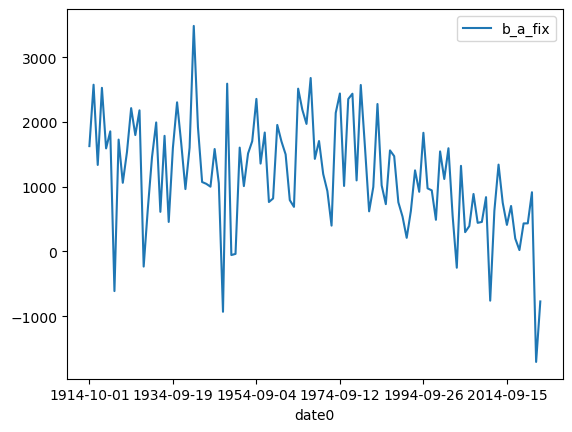

In [9]:
# Example:
fileName = 'clariden_U_mb.csv'
dfStake = pd.read_csv(path_xycoord + fileName, sep=',', header=0)
dfStake.sort_values(by='date0').plot(x='date0', y='b_a_fix')

### Transform coordinates to lat/lon (from swiss system):

In [10]:
path_latloncoord = '../../data/MB_modeling/GLAMOS/index/csv_files/massbalance/WGSlatloncoord/'
RUN = True
if RUN:
    # First empty folder
    emptyfolder(path_latloncoord)
    # Convert to lat/lon
    for key in glStakes.keys():
        for fileName in glStakes[key]:
            df = pd.read_csv(path_xycoord + fileName, sep=',', header=0)
            df_processed = LV03toWGS84(df)
            df_processed.to_csv(path_latloncoord + fileName)
# Example:  
fileName = 'aletsch_P0_mb.csv'
df = pd.read_csv(path_latloncoord + fileName, sep=',', header=0)
df.head(2)

,Unnamed: 0.1,Unnamed: 0,meas_id,date0,date_fmeas,date_fmin,date_smeas,date_smax,date1,b_w_meas,...,a_a_fix,date_fix0,date_fix1,sgi_id,glims_id,rgi_id,vaw_id,lat,lon,height
0,0,0,3,1995-10-12,1995-10-01,1995-11-17,1996-04-30,1996-04-19,1996-10-11,-1110,...,-10195,1995-10-01,1996-09-30,B36-26,G008032E46504N,RGI60-11.01450,3,46.413308,8.054188,2089.502943
1,1,1,3,1996-10-11,1996-10-01,1996-11-13,1997-04-30,1997-02-19,1997-10-09,-271,...,-11996,1996-10-01,1997-09-30,B36-26,G008032E46504N,RGI60-11.01450,3,46.413308,8.054188,2089.202943
